In [1]:
from pathlib import Path
files = sorted(Path("data/raw/net").glob("*"))
len(files), files[:5]

(17,
 [WindowsPath('data/raw/net/https_ajax_googleapis_com_ajax_libs_jquery_1_8_3_jquery_min_js_055d28.bin'),
  WindowsPath('data/raw/net/https_ajax_googleapis_com_ajax_libs_jqueryui_1_9_1_jquery_ui_min_js_bed17e.bin'),
  WindowsPath('data/raw/net/https_fonts_googleapis_com_css_family_exo_400_600_800_26bc18.bin'),
  WindowsPath('data/raw/net/https_fonts_googleapis_com_css_family_open_sans_400italic_300_400_600_700_b0e05c.bin'),
  WindowsPath('data/raw/net/https_fonts_googleapis_com_css_family_open_sans_condensed_700_7fb311.bin')])

In [2]:
from pathlib import Path
import re
import pandas as pd

# 1) Localiza el .bin con valores de WPC (ajusta si fuera otro nombre)
netdir = Path("data/raw/net")
bin_path = next(netdir.glob("*getgenericvaluemaxminwithnull4*prezzo_whey*/*.bin"), None)
if bin_path is None:
    # a veces no hay subcarpeta; probamos en el propio directorio
    bin_path = next(netdir.glob("*getgenericvaluemaxminwithnull4*prezzo_whey*.bin"))

text = bin_path.read_text(encoding="utf-8", errors="ignore")

# 2) Extrae la lista de valores
m_vals = re.search(r"values\s*=\s*([0-9\.,\s\-NaN]+)", text)
if not m_vals:
    raise ValueError("No se encontró 'values=' en el archivo.")

vals_raw = m_vals.group(1)
# normaliza y convierte
values = []
for x in re.split(r"[,\s]+", vals_raw.strip()):
    if x == "" or x.lower() == "nan":
        values.append(None)
    else:
        try:
            values.append(float(x))
        except:
            values.append(None)

# 3) Intenta extraer fechas explícitas si existen (dates= o labels= con ISO)
m_dates = re.search(r"dates\s*=\s*([0-9,\-\s]+)", text) or re.search(r"labels\s*=\s*([0-9,\-\s:TZ]+)", text)
dates = None
if m_dates:
    dates_raw = m_dates.group(1)
    # separa por coma o espacios
    parts = [p.strip() for p in re.split(r"[,\s]+", dates_raw.strip()) if p.strip()]
    # convierte a fecha
    dconv = pd.to_datetime(parts, errors="coerce")
    if dconv.notna().sum() >= len(values) * 0.5:  # heurística
        dates = dconv.dt.date.tolist()

# 4) Si no hay fechas, derivamos el start date de la propia ruta
if dates is None:
    # la ruta original de CLAL está embedida en el nombre del archivo; buscamos _min_YYYY_MM_DD_
    m_start = re.search(r"_min_(\d{4})_(\d{2})_(\d{2})_", bin_path.name)
    if not m_start:
        raise ValueError("No se pudo deducir start date desde el nombre del archivo.")
    y, mo, d = map(int, m_start.groups())
    start = pd.Timestamp(year=y, month=mo, day=d)
    # asumimos periodicidad mensual (CLAL usa mensual para series 'avg_m')
    freq = "MS"  # Month Start
    dates = pd.date_range(start=start, periods=len(values), freq=freq).date

# 5) Construye el DataFrame y limpia nulos
df = pd.DataFrame({"date": dates, "price": values})
df = df.dropna(subset=["price"])
df = df.sort_values("date")

# 6) Añade metadatos y guarda el CSV final
df.insert(0, "commodity", "WPC")
df.insert(1, "geography", "World")
df.insert(2, "spec", "WPC – avg (CLAL getgeneric)")
df["unit"] = "USD/Tons"  # el y-axis en tu JSON indicaba USD/Tons
df["source_url"] = "https://www.clal.it/en/index.php?section=demi"

out = df[["commodity","geography","spec","date","price","unit","source_url"]]
out.to_csv("data/clal_powders_prices.csv", index=False)
len(out), out.head()

(70,
   commodity geography                         spec        date    price  \
 0       WPC     World  WPC – avg (CLAL getgeneric)  2020-01-01  2206.29   
 1       WPC     World  WPC – avg (CLAL getgeneric)  2020-02-01  2235.64   
 2       WPC     World  WPC – avg (CLAL getgeneric)  2020-03-01  2237.70   
 3       WPC     World  WPC – avg (CLAL getgeneric)  2020-04-01  2223.92   
 4       WPC     World  WPC – avg (CLAL getgeneric)  2020-05-01  2119.76   
 
        unit                                     source_url  
 0  USD/Tons  https://www.clal.it/en/index.php?section=demi  
 1  USD/Tons  https://www.clal.it/en/index.php?section=demi  
 2  USD/Tons  https://www.clal.it/en/index.php?section=demi  
 3  USD/Tons  https://www.clal.it/en/index.php?section=demi  
 4  USD/Tons  https://www.clal.it/en/index.php?section=demi  )

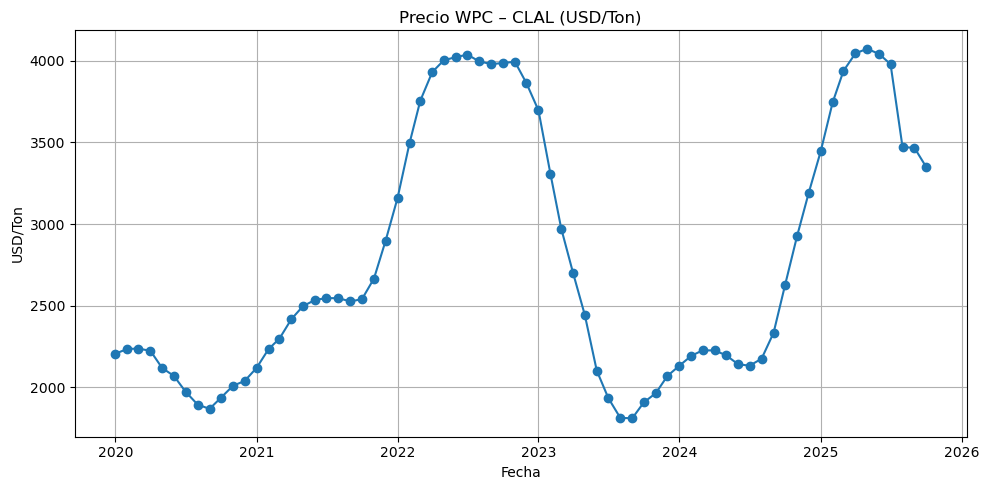

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/clal_powders_prices.csv", parse_dates=["date"]).sort_values("date")

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df["date"], df["price"], marker="o")  
ax.set_title("Precio WPC – CLAL (USD/Ton)")
ax.set_xlabel("Fecha")
ax.set_ylabel("USD/Ton")
ax.grid(True)

fig.tight_layout()
fig.savefig("data/wpc_price_trend.png", dpi=150, bbox_inches="tight")

plt.show()
plt.close(fig)  